# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [29]:
import sys
from pathlib import Path

# Add the src directory to sys.path
root_dir = Path().absolute().parent.parent
# Add project root to the path of Python
sys.path.append(str(root_dir))

from src import config  # noqa: E402

settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

In [30]:
import datetime
import json

import hopsworks
import pandas as pd
from xgboost import XGBRegressor

from src.utils import util

In [36]:
today = datetime.datetime.now() - datetime.timedelta(5)
tomorrow = today + datetime.timedelta(days=1)
today

datetime.datetime(2025, 5, 13, 14, 26, 18, 516055)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [32]:
project = hopsworks.login()
fs = project.get_feature_store()

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country = location["country"]
city = location["city"]
street = location["street"]

2025-05-18 14:25:53,564 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-18 14:25:53,568 INFO: Initializing external client
2025-05-18 14:25:53,568 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-18 14:25:54,919 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1224891


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [33]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-05-18 14:26:00,034 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/489855 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/71967 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20844 elapsed<00:00 remaining<?

In [34]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='5.8326572E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'],
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [37]:
weather_fg = fs.get_feature_group(
    name="weather",
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.59s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-05-16 00:00:00+00:00,18.730999,10.400001,7.020000,308.210968,medellin
1,2025-05-15 00:00:00+00:00,18.787249,14.400000,6.618519,265.855408,medellin
2,2025-05-14 00:00:00+00:00,18.991415,11.800000,6.756597,293.198334,medellin


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [38]:
batch_data["predicted_pm25"] = retrieved_xgboost_model.predict(
    batch_data[
        [
            "temperature_2m_mean",
            "precipitation_sum",
            "wind_speed_10m_max",
            "wind_direction_10m_dominant",
        ]
    ]
)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-05-16 00:00:00+00:00,18.730999,10.400001,7.020000,308.210968,medellin,48.001110
1,2025-05-15 00:00:00+00:00,18.787249,14.400000,6.618519,265.855408,medellin,45.621002
2,2025-05-14 00:00:00+00:00,18.991415,11.800000,6.756597,293.198334,medellin,58.621010


In [39]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         3 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          3 non-null      float32                
 2   precipitation_sum            3 non-null      float32                
 3   wind_speed_10m_max           3 non-null      float32                
 4   wind_direction_10m_dominant  3 non-null      float32                
 5   city                         3 non-null      object                 
 6   predicted_pm25               3 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 240.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [40]:
batch_data["street"] = street
batch_data["city"] = city
batch_data["country"] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data["days_before_forecast_day"] = range(1, len(batch_data) + 1)
batch_data = batch_data.sort_values(by=["date"])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
2,2025-05-14 00:00:00+00:00,18.991415,11.800000,6.756597,293.198334,medellin,58.621010,el-poblado,colombia,3
1,2025-05-15 00:00:00+00:00,18.787249,14.400000,6.618519,265.855408,medellin,45.621002,el-poblado,colombia,2
0,2025-05-16 00:00:00+00:00,18.730999,10.400001,7.020000,308.210968,medellin,48.001110,el-poblado,colombia,1


In [41]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 2 to 0
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         3 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          3 non-null      float32                
 2   precipitation_sum            3 non-null      float32                
 3   wind_speed_10m_max           3 non-null      float32                
 4   wind_direction_10m_dominant  3 non-null      float32                
 5   city                         3 non-null      object                 
 6   predicted_pm25               3 non-null      float32                
 7   street                       3 non-null      object                 
 8   country                      3 non-null      object                 
 9   days_before_forecast_day     3 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

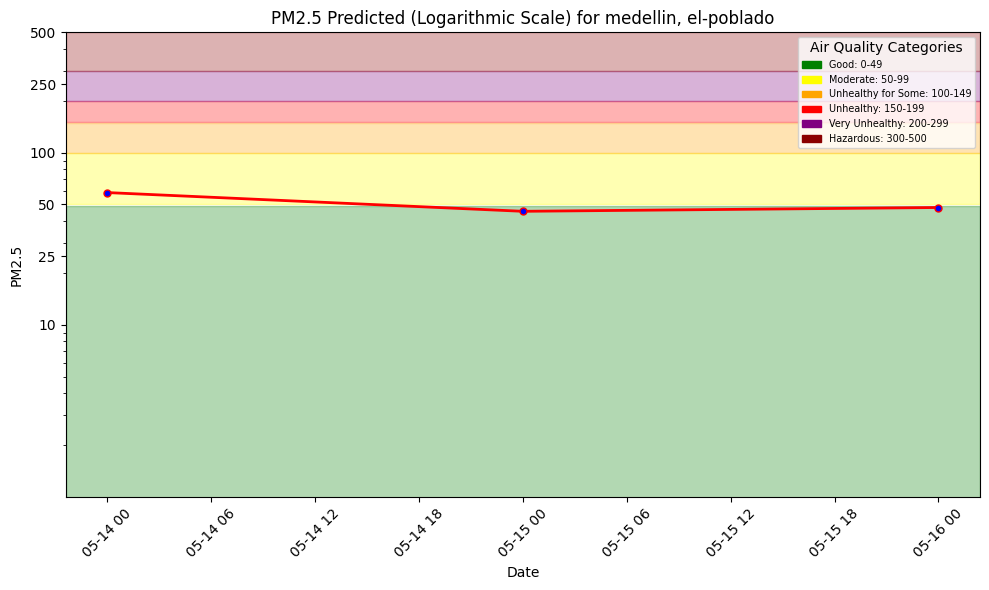

In [42]:
pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
figure = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

figure.show()

In [43]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name="aq_predictions",
    description="Air Quality prediction monitoring",
    version=1,
    primary_key=["city", "street", "date", "days_before_forecast_day"],
    event_time="date",
)

In [44]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 3/3 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1224891/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-05-18 14:27:21,928 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-05-18 14:27:25,152 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-05-18 14:29:22,648 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-05-18 14:29:25,823 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-05-18 14:29:25,987 INFO: Waiting for log aggregation to finish.
2025-05-18 14:29:44,670 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [45]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.97s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-05-16 00:00:00+00:00,18.730999,10.400001,7.02,308.210968,medellin,48.00111,el-poblado,colombia,1


In [46]:
air_quality_fg = fs.get_feature_group(name="air_quality", version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 


,date,pm25,country,city,street,url
0,2022-04-12 00:00:00+00:00,59.0,colombia,medellin,el-poblado,https://api.waqi.info/feed/@12635
1,2021-07-03 00:00:00+00:00,58.0,colombia,medellin,el-poblado,https://api.waqi.info/feed/@12635
2,2021-04-05 00:00:00+00:00,42.0,colombia,medellin,el-poblado,https://api.waqi.info/feed/@12635
3,2020-02-22 00:00:00+00:00,90.0,colombia,medellin,el-poblado,https://api.waqi.info/feed/@12635
4,2025-04-28 00:00:00+00:00,47.0,colombia,medellin,el-poblado,https://api.waqi.info/feed/@12635
...,...,...,...,...,...,...
1931,2020-06-11 00:00:00+00:00,54.0,colombia,medellin,el-poblado,https://api.waqi.info/feed/@12635
1932,2022-12-16 00:00:00+00:00,53.0,colombia,medellin,el-poblado,https://api.waqi.info/feed/@12635
1933,2024-05-05 00:00:00+00:00,61.0,colombia,medellin,el-poblado,https://api.waqi.info/feed/@12635
1934,2024-10-11 00:00:00+00:00,37.0,colombia,medellin,el-poblado,https://api.waqi.info/feed/@12635


In [47]:
outcome_df = air_quality_df[["date", "pm25"]]
preds_df = monitoring_df[["date", "predicted_pm25"]]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=["date"])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(
        weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model
    )
hindcast_df

,date,predicted_pm25,pm25
0,2025-05-16 00:00:00+00:00,48.00111,56.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

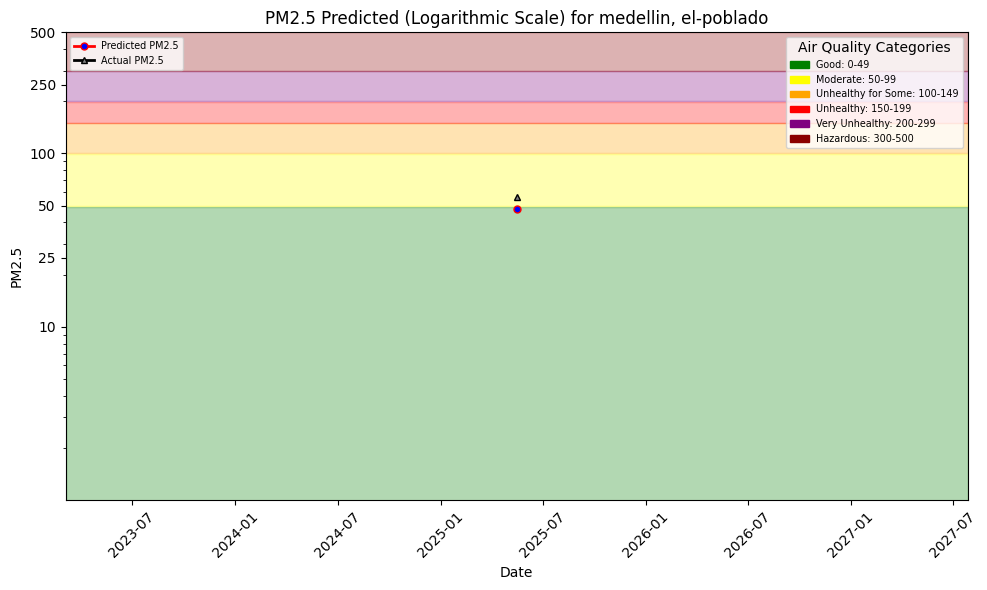

In [48]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
fig = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
fig.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if not dataset_api.exists("Resources/airquality"):
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(
    pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True
)
dataset_api.upload(
    hindcast_file_path,
    f"Resources/airquality/{city}_{street}_{str_today}",
    overwrite=True,
)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /media/joser/Datos/Github/air-quality-fti/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|    …

Uploading /media/joser/Datos/Github/air-quality-fti/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1224891/settings/fb/path/Resources/airquality


---